In [1]:
import numpy as np
import pandas as pd
import seaborn as sea
import category_encoders
import matplotlib.pyplot as plt

from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline as pipe
from sklearn.base import clone

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet

from sklearn.metrics import r2_score
import optuna

import joblib
import warnings 
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("/kaggle/input/predicting-the-price-of-diamond/train.csv")
test  = pd.read_csv("/kaggle/input/predicting-the-price-of-diamond/test.csv")
sample_submission = pd.read_csv("/kaggle/input/predicting-the-price-of-diamond/submission.csv")

train.drop(columns=["id"], inplace=True)
test.drop(columns=["id"], inplace=True)

In [3]:
train.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.31,Ideal,H,VS2,61.8,57.0,4.39,4.36,2.68,681.0
1,0.38,Ideal,G,VVS1,60.8,56.0,4.67,4.73,2.89,1132.0
2,0.38,Very Good,G,SI1,61.0,56.0,4.68,4.64,2.81,1307.0
3,0.71,Premium,H,SI1,60.6,58.0,5.83,5.80,3.49,1308.0
4,0.31,Very Good,G,IF,62.0,57.0,4.32,4.36,2.70,645.0


In [4]:
## Inspects whether categorical features in train and test have the same values
for feature in ["cut", "color", "clarity"]:
    status = "yes" if set(train[feature].unique()) == set(test[feature].unique()) else "no"
    print(f"Does {feature} have the same lebels between train and test set? {status}")
    print()

Does cut have the same lebels between train and test set? no

Does color have the same lebels between train and test set? no

Does clarity have the same lebels between train and test set? no



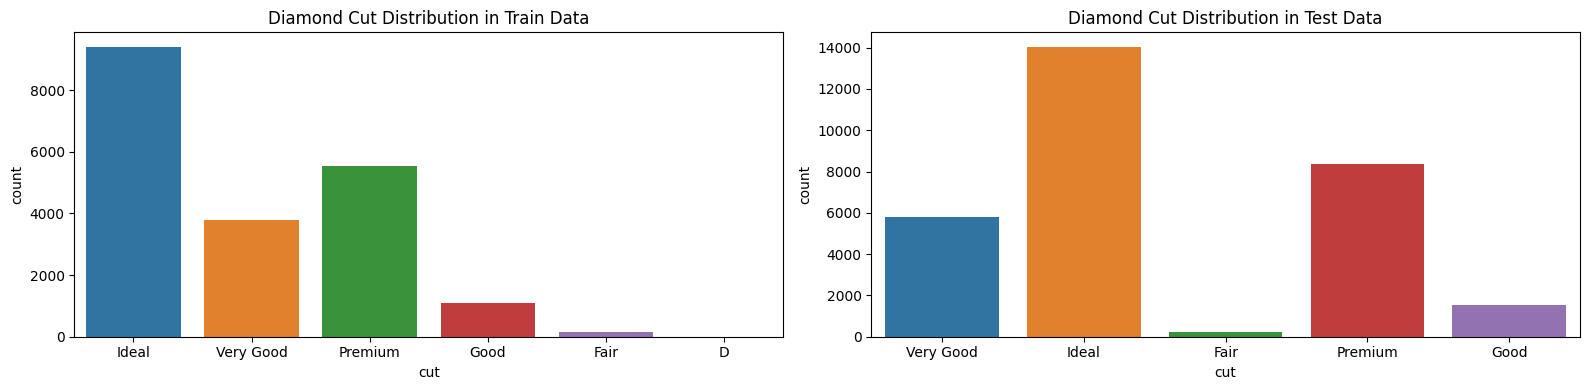

In [5]:
plt.figure(figsize=(16,4))
plt.subplot(121)
sea.countplot(data=train, x="cut")
plt.title("Diamond Cut Distribution in Train Data")

plt.subplot(122)
sea.countplot(data=test, x="cut")
plt.title("Diamond Cut Distribution in Test Data")
plt.tight_layout()
plt.show()

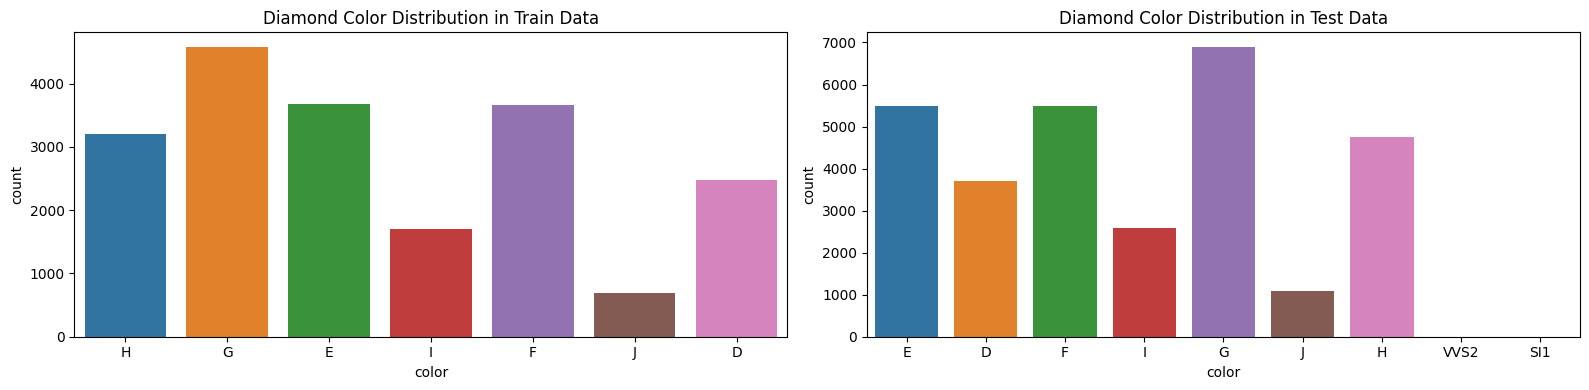

In [6]:
plt.figure(figsize=(16,4))
plt.subplot(121)
sea.countplot(data=train, x="color")
plt.title("Diamond Color Distribution in Train Data")

plt.subplot(122)
sea.countplot(data=test, x="color")
plt.title("Diamond Color Distribution in Test Data")
plt.tight_layout()
plt.show()

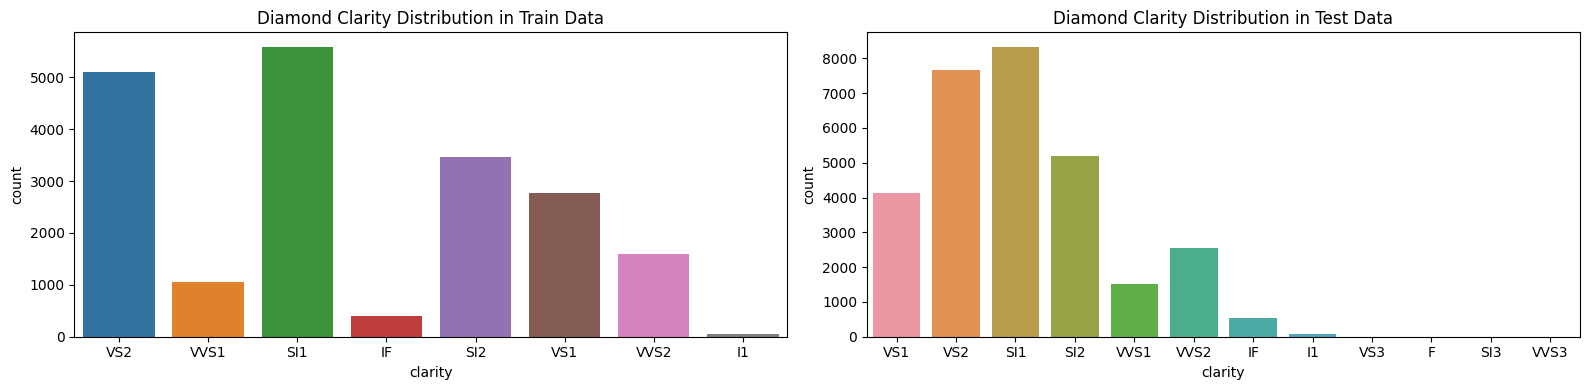

In [7]:
plt.figure(figsize=(16,4))
plt.subplot(121)
sea.countplot(data=train, x="clarity")
plt.title("Diamond Clarity Distribution in Train Data")

plt.subplot(122)
sea.countplot(data=test, x="clarity")
plt.title("Diamond Clarity Distribution in Test Data")
plt.tight_layout()
plt.show()

In [8]:
# ## Filters out outlier 'cut' category in train data
# train = train.loc[(train["cut"]!="D")]
# train.reset_index(drop=True, inplace=True)

In [9]:
## Splits train dataset to X and y 
X = train.copy()
y = X.pop("price")

# Evaluation of OneHotEncoder

In [10]:
preprocessor = ColumnTransformer(
    [("cat_encode", OneHotEncoder(), ["cut", "color", "clarity"]),
     ("num_scale", StandardScaler(), ["carat", "depth", "table", "x", "y", "z"])],
    remainder="passthrough",
    n_jobs=-1
).set_output(transform="pandas")

In [11]:
train_new = preprocessor.fit_transform(train)

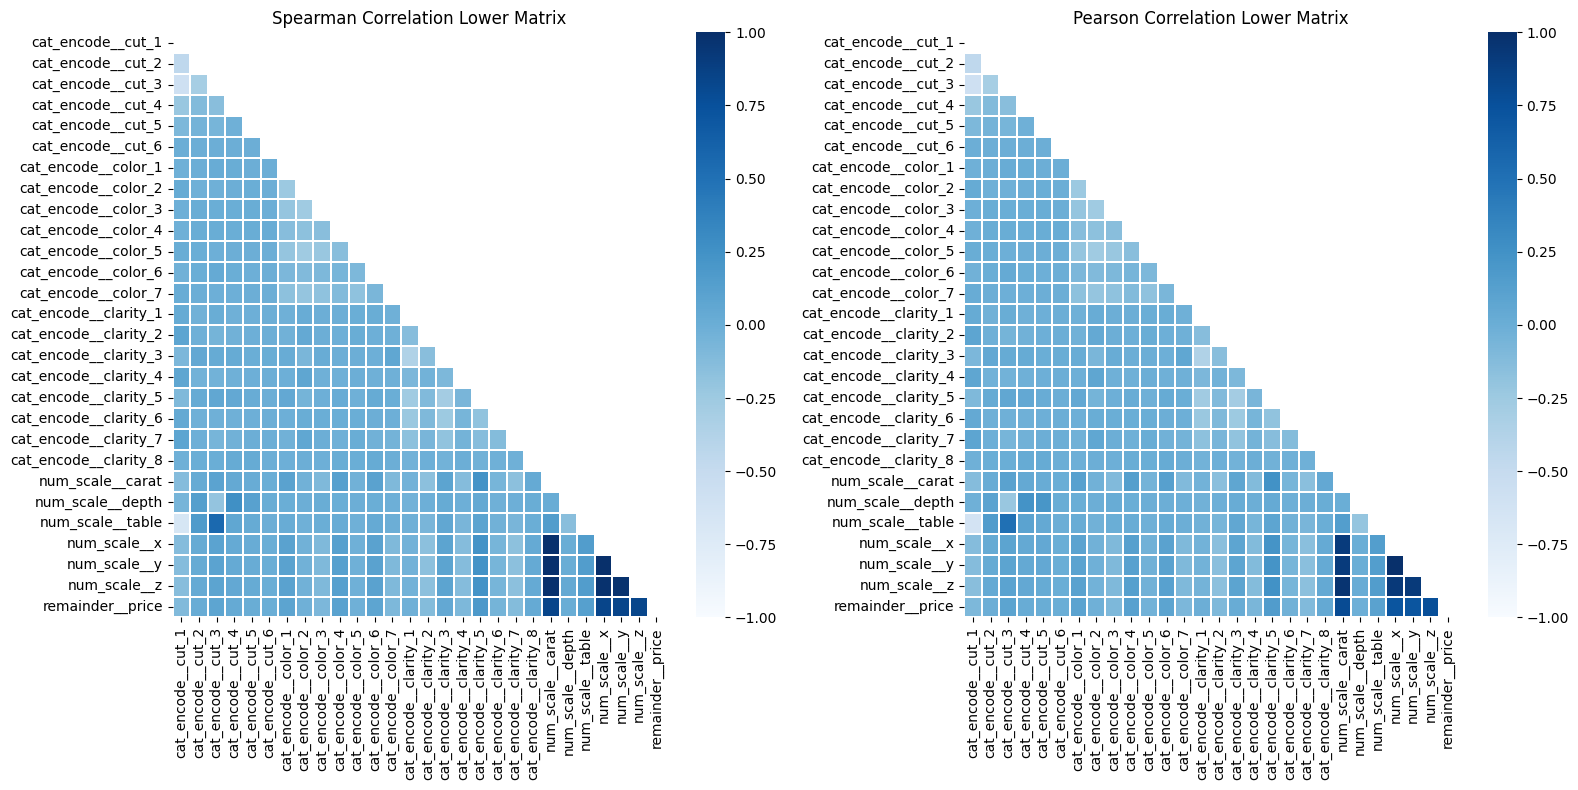

In [12]:
plt.figure(figsize=(16,8))

plt.subplot(121)
M_spearman = train_new.corr(method="spearman")
U = np.triu(M_spearman)
sea.heatmap(M_spearman, mask=U, cmap="Blues", vmin=-1, vmax=1, linewidths=.1, linecolor="white")
plt.title("Spearman Correlation Lower Matrix")

plt.subplot(122)
M_pearson = train_new.corr(method="pearson")
U = np.triu(M_pearson)
sea.heatmap(M_pearson, mask=U, cmap="Blues", vmin=-1, vmax=1, linewidths=.1, linecolor="white")
plt.title("Pearson Correlation Lower Matrix")

plt.tight_layout()
plt.show()

In [13]:
def cross_validate(model, X, y, n_splits=22):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=3126)
    y_oof = np.zeros_like(y, dtype=float)
    r2_scores  = []
    history = {}
        
    for train_idx,val_idx in kfold.split(X):
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_val,   y_val   = X.iloc[val_idx],   y[val_idx]

        ## Fits cloned model
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        ## Gets OOF prediction and stores it
        y_pred = cloned_model.predict(X_val)
        y_oof[val_idx] = y_pred
        ## Stores metric
        r2_scores.append(r2_score(y_val, y_pred))

    history["y_oof"] = y_oof
    history["r2"]  = np.array(r2_scores)
    return history

In [14]:
# def objective(trial):
#     ## Parameter to tune
#     alpha = trial.suggest_float("alpha", .005, 10, log=True)

#     ## Cross validates model
#     preprocessor = ColumnTransformer(
#         [("cat_encode", OneHotEncoder(), ["cut", "color", "clarity"]),
#          ("num_scale", StandardScaler(), ["carat", "depth", "table", "x", "y", "z"])],
#         remainder="passthrough",
#         n_jobs=-1
#     ).set_output(transform="pandas")
    
#     ridge = pipe(
#         preprocessor, 
#         Ridge(alpha=alpha, random_state=3126)
#     )
    
#     history = cross_validate(ridge, X, y)
#     return history["r2"].mean()
    
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# # Best parameters
# print("Best trial:")
# trial = study.best_trial
# print("R2:", trial.value)
# print("Params:", trial.params)

In [15]:
# def objective(trial):
#     ## Parameter to tune
#     alpha    = trial.suggest_float("alpha", .005, 10, log=True)
#     l1_ratio = trial.suggest_float("l1_ratio", .1, .9, log=True)
    
#     ## Cross validates model
#     preprocessor = ColumnTransformer(
#         [("cat_encode", OneHotEncoder(), ["cut", "color", "clarity"]),
#          ("num_scale", StandardScaler(), ["carat", "depth", "table", "x", "y", "z"])],
#         remainder="passthrough",
#         n_jobs=-1
#     ).set_output(transform="pandas")
    
#     enet = pipe(
#         preprocessor, 
#         ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=3126)
#     )
    
#     history = cross_validate(enet, X, y)
#     return history["r2"].mean()
    
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# # Best parameters
# print("Best trial:")
# trial = study.best_trial
# print("R2:", trial.value)
# print("Params:", trial.params)

In [16]:
## .6308 R2
ridge_alpha = 9.996145403046302

## .6310 R2
enet_params = {
    'alpha': 0.006288725368608656, 
    'l1_ratio': 0.4822804975376506
}

## Initializes preprocessor
preprocessor = ColumnTransformer(
    [("cat_encode", OneHotEncoder(), ["cut", "color", "clarity"]),
     ("num_scale", StandardScaler(), ["carat", "depth", "table", "x", "y", "z"])],
    remainder="passthrough",
    n_jobs=-1
).set_output(transform="pandas")


## Define models
ridge = pipe(
    preprocessor, 
    Ridge(alpha=ridge_alpha, random_state=3126)
)

enet = pipe(
    preprocessor, 
    ElasticNet(**enet_params, random_state=3126)
) 

In [17]:
history_ridge = cross_validate(ridge, X, y)
history_enet = cross_validate(enet, X, y)

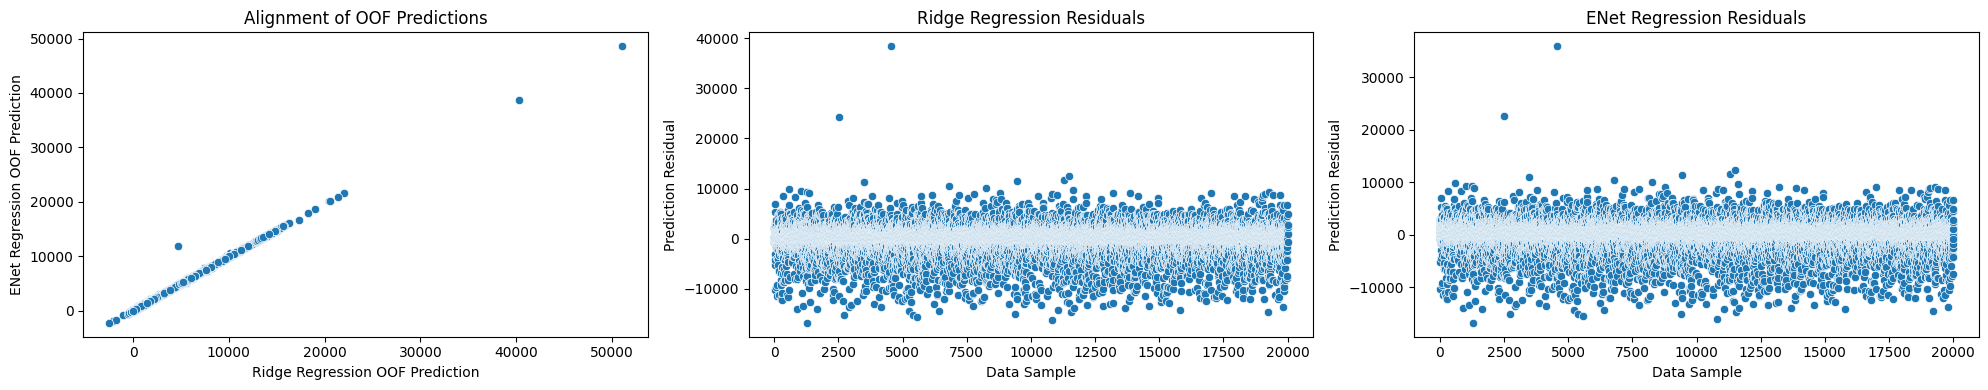

In [18]:
plt.figure(figsize=(20,4))

plt.subplot(131)
sea.scatterplot(x=history_ridge["y_oof"], y=history_enet["y_oof"])
plt.xlabel("Ridge Regression OOF Prediction")
plt.ylabel("ENet Regression OOF Prediction")
plt.title("Alignment of OOF Predictions")

plt.subplot(132)
sea.scatterplot(x=np.arange(1, len(y)+1), y=history_ridge["y_oof"]-y)
plt.xlabel("Data Sample")
plt.ylabel("Prediction Residual")
plt.title("Ridge Regression Residuals")

plt.subplot(133)
sea.scatterplot(x=np.arange(1, len(y)+1), y=history_enet["y_oof"]-y)
plt.xlabel("Data Sample")
plt.ylabel("Prediction Residual")
plt.title("ENet Regression Residuals")

plt.tight_layout()
plt.show()

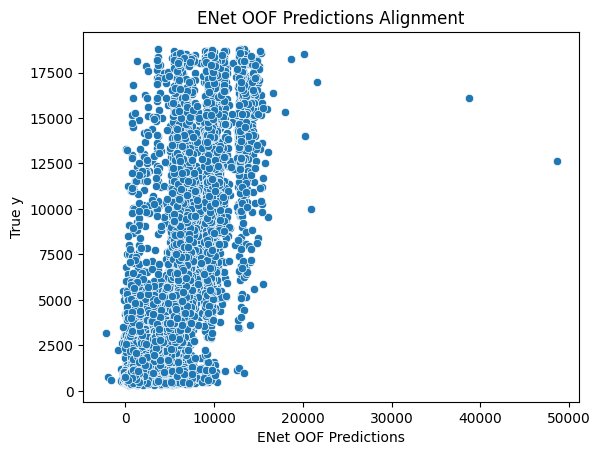

In [19]:
sea.scatterplot(x=history_enet["y_oof"], y=y)
plt.xlabel("ENet OOF Predictions")
plt.ylabel("True y")
plt.title("ENet OOF Predictions Alignment")
plt.show()

In [20]:
enet.fit(X, y)
y_pred = enet.predict(test)

In [21]:
sample_submission["price"] = y_pred

In [22]:
sample_submission.to_csv("submission.csv", index=False)